In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import time

In [2]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))


device name NVIDIA GeForce RTX 3060 Ti


In [3]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True, norm_zero_to_one=False):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.norm_zero_to_one = norm_zero_to_one
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):    
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        
        rgb_normed = raw_rgb / np.iinfo(raw_rgb.dtype).max
        
        if self.norm_zero_to_one:
            # Corrected to -1,1 normalization
            return rgb_normed * 2 - 1

        # normalize
        return rgb_normed
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y

In [4]:
# True if we want to normalize the images from -1, 1, otherwise they will be 0,1
norm_zero_to_one = False

base_path = Path('data/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt', norm_zero_to_one=norm_zero_to_one)
len(data)


8400

In [5]:
# returns features x and target feature y
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

In [6]:
# Check image range 
x.min(), x.max()

(tensor(0.1020), tensor(0.9530))

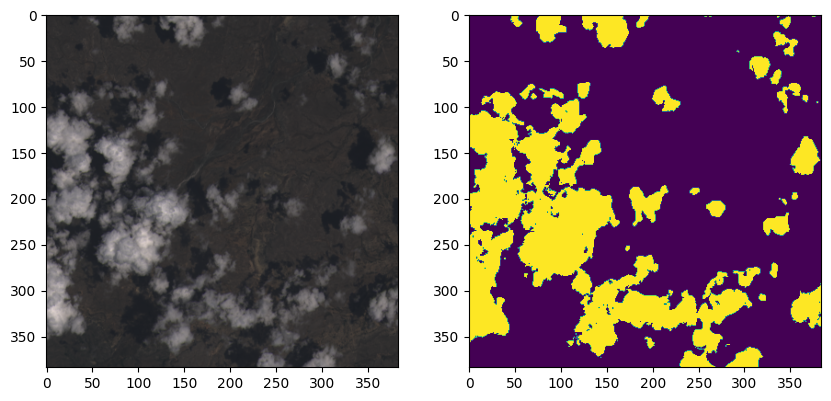

In [7]:
# visualize raw image and ground truth
image_index = 1000

fig, ax = plt.subplots(1,2, figsize=(10,9))

if norm_zero_to_one:
    ax[0].imshow((data.open_as_array(image_index)[:,:,:3] + 1) * 0.5)
else:
    ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))

# left -> raw image
# right Ground-Truth Mask (as binary image)

In [8]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
        
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def __call__(self, x):
        x = self.quant(x)
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        upconv1 = self.dequant(upconv1)
        return upconv1
    
    def keep_images(self, x, threshold):
        y = self.__call__(x)
        y_probs = nn.functional.softmax(y, dim=1)
        y_pred = torch.argmax(y_probs, dim=1).float()
        y_mean = torch.mean(y_pred, dim=(1,2))
        
        return y_mean < threshold

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand

In [9]:
unet = UNET(4,2)

In [10]:
train_dataset, valid_dataset = torch.utils.data.random_split(data, (6000, 2400))

train_dataload = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataload = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# test dataload
xb, yb = next(iter(train_dataload))
print(xb.shape, yb.shape)

pred = unet(xb)
print("Output shape: ", pred.shape)

torch.Size([16, 4, 384, 384]) torch.Size([16, 384, 384])
Output shape:  torch.Size([16, 2, 384, 384])


In [11]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1, hyperbatch_size=3):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dataload
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dataload

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':        
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    loss.backward()
                    
                    if step % hyperbatch_size == 0:
                        optimizer.step()
                        optimizer.zero_grad()
                        
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [12]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(unet.parameters(), lr=0.003) # choose gradient function

# start training
unet.train()
train_loss, valid_loss = train(unet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2, hyperbatch_size=3)
print(train_loss, valid_loss)

Epoch 1/1
----------
valid Loss: 0.3004 Acc: 0.8987328410148621
----------
Training complete in 4m 17s
[tensor(0.4642, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.3547, device='cuda:0', grad_fn=<DivBackward0>)] [tensor(0.3682, device='cuda:0'), tensor(0.3004, device='cuda:0')]


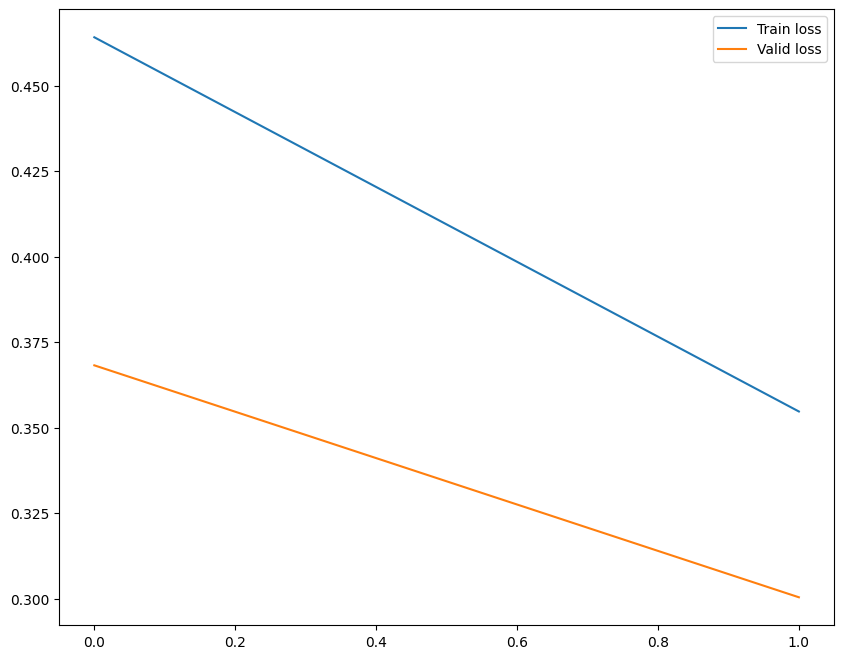

In [13]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot([tl.detach().cpu() for tl in train_loss], label='Train loss')
plt.plot([vl.detach().cpu() for vl in valid_loss], label='Valid loss')
plt.legend()

In [14]:
def batch_to_img(xb, idx, norm_to_zero_one=False):
    img = np.array(xb[idx,0:3])
    img = img.transpose((1,2,0))
    if norm_to_zero_one:
        img = (img + 1) * 0.5
    return img

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [15]:
xb, yb = next(iter(train_dataload))

unet = unet.cpu()
with torch.no_grad():
    predb = unet(xb)

predb.shape

torch.Size([16, 2, 384, 384])

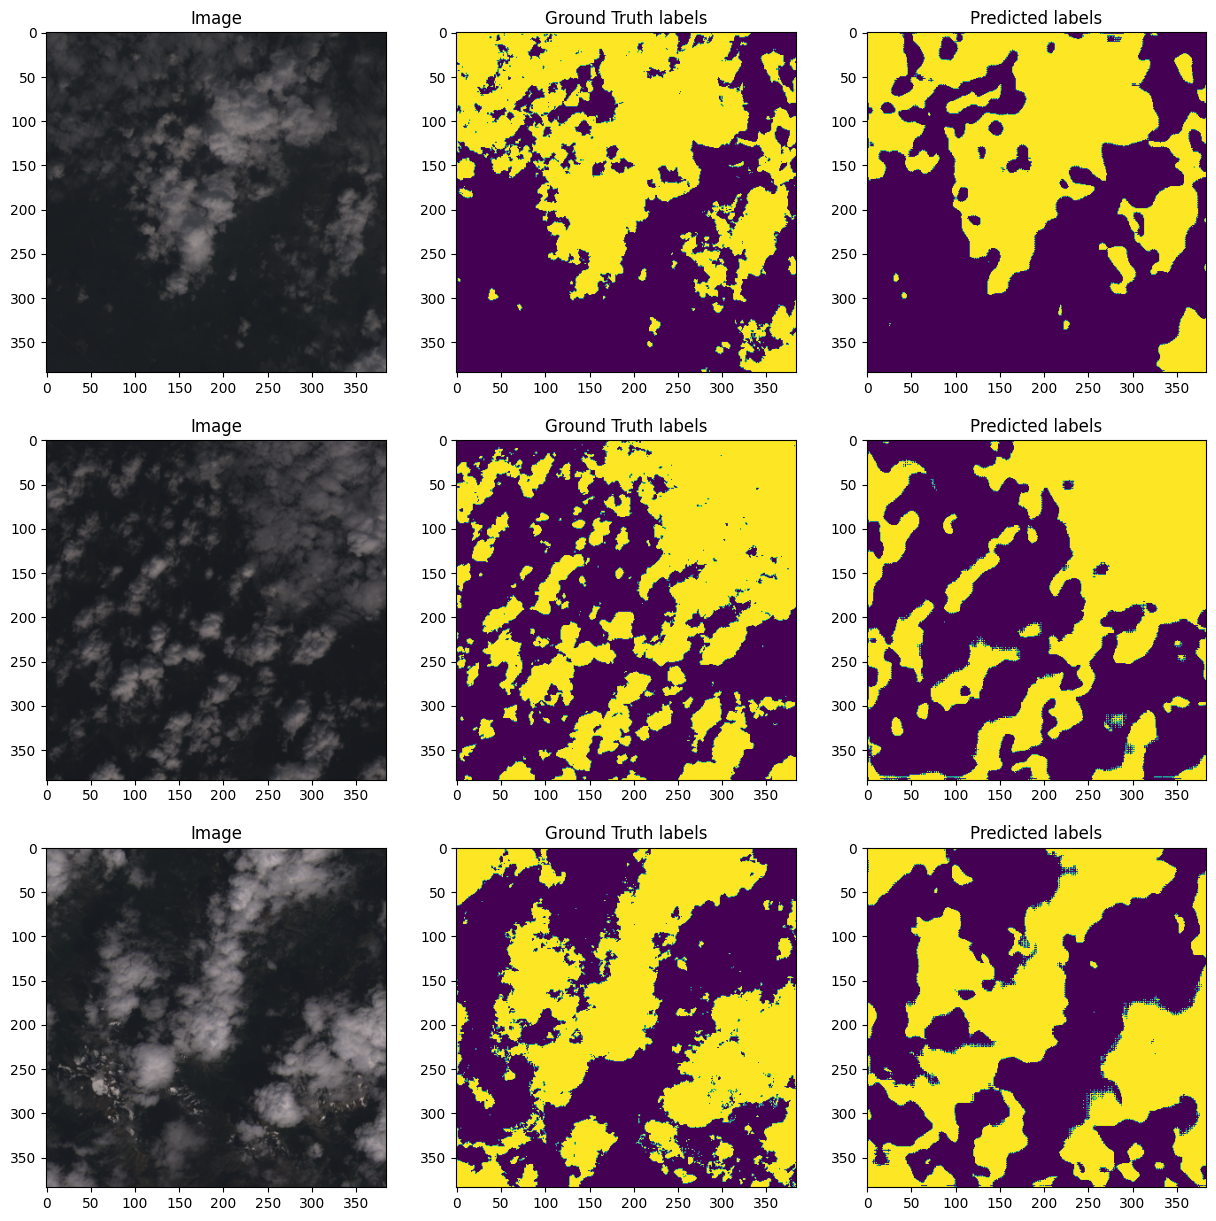

In [16]:
bs = 3
fig, ax = plt.subplots(bs, 3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i, norm_zero_to_one))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))
    
    ax[i,0].set_title("Image")
    ax[i,1].set_title("Ground Truth labels")
    ax[i,2].set_title("Predicted labels")

In [17]:
from timeit import default_timer as timer

# Make a model speed benchmark for cpu and GPU 
def time_nn_model(model, x, use_cuda=False):
    if use_cuda:
        x = x.cuda()
        model = model.cuda()
        
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()
        with torch.no_grad():
            y_ = model(x)
        end.record()

        # Waits for everything to finish running
        torch.cuda.synchronize()
        
        elapsed_time = start.elapsed_time(end)
    else:
        if x.is_cuda:
            x = x.cpu()
        model = model.cpu()
        
        time_sum = 0
        n_trials = 7 
        with torch.no_grad():
            for i in range(n_trials):    
                start = timer()
                y_ = model(x)
                end = timer()
                time_sum += (end-start)
        elapsed_time = (time_sum / n_trials) * 1000

    return elapsed_time

In [18]:
_ = unet.eval()

unet = unet.cpu()
unet.qconfig = torch.quantization.get_default_qconfig('qnnpack')

model_fp32_fused = torch.quantization.fuse_modules(unet, [["conv1.0", "conv1.1", "conv1.2"],
                                                ["conv1.3", "conv1.4", "conv1.5"],
                                                ["conv2.0", "conv2.1", "conv2.2"],
                                                ["conv2.3", "conv2.4", "conv2.5"],
                                                ["conv3.0", "conv3.1", "conv3.2"],
                                                ["conv3.3", "conv3.4", "conv3.5"],
                                                ["upconv3.0", "upconv3.1", "upconv3.2"],
                                                ["upconv3.3", "upconv3.4", "upconv3.5"],
                                                ["upconv2.0", "upconv2.1", "upconv2.2"],
                                                ["upconv2.3", "upconv2.4", "upconv2.5"],
                                                ["upconv1.0", "upconv1.1", "upconv1.2"],
                                                ["upconv1.3", "upconv1.4", "upconv1.5"]])


model_fp32_prepared = torch.quantization.prepare(model_fp32_fused)

"""
Specify which parts of the model need to be quantized either by assigning .qconfig
attributes on submodules or by specifying qconfig_dict. For example, setting model.conv1.qconfig 
= None means that the model.conv layer will not be quantized, and setting model.linear1.qconfig = custom_qconfig
means that the quantization settings for model.linear1 will be using custom_qconfig instead of the global qconfig.

NOTE: For the fbgemm backend, you have to set the qconfig of the upconvolutional layers to none using the above manual and also add quant/dequant stubs before and after those layers.
"""

# Specify how many batches to get quantization calibration statistics over
n_batches = 80

# TODO: Find out if it's better to calibrate on training or validation data (probably training data)
for i, (batch, target) in enumerate(train_dataload):
    model_fp32_prepared(batch)
    
    if ctr > n_batches:
        break

unet_int8 = torch.quantization.convert(model_fp32_prepared)
xb, yb = next(iter(train_dataload))
res = unet_int8(xb)

In [19]:
#torch.nn.Conv2d
#torch.nn.BatchNorm2d
#torch.nn.ReLU
#torch.nn.MaxPool2d
#torch.nn.ConvTranspose2d

import os

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
    
print_size_of_model(unet)
print_size_of_model(unet_int8)

Size (MB): 2.187671
Size (MB): 0.559275


In [20]:
batchsize = 8
train_dataload = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
valid_dataload = DataLoader(valid_dataset, batch_size=batchsize, shuffle=True)
xb, yb = next(iter(train_dataload))

#time_taken_gpu = time_nn_model(unet_int8, xb, use_cuda=True)
time_taken_gpu = time_nn_model(unet, xb, use_cuda=True)
time_taken_cpu = time_nn_model(unet, xb, use_cuda=False)
time_taken_cpu_quant = time_nn_model(unet_int8, xb, use_cuda=False)
    
print(f"Forward pass per image: {round(time_taken_cpu / batchsize, 2)} ms on cpu, {round(time_taken_cpu_quant / batchsize, 2)} ms on cpu with quantization, {round(time_taken_gpu / batchsize, 2)} ms on gpu")

Forward pass per image: 113.39 ms on cpu, 62.01 ms on cpu with quantization, 6.7 ms on gpu


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
from torchmetrics import ConfusionMatrix, F1Score, PrecisionRecallCurve
from torch.nn.functional import softmax
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

def evaluate_model(model, eval_dataset, model_name):
    x_list = []
    y_list = []
    y_pred_list = []
    
    # For batchnorm, dropout, etc
    model.eval()
    
    # Evaluate model on the whole validation set, batch by batch
    ctr = 0
    for x, y in eval_dataset:
        with torch.no_grad():
            y_pred = model(x)
            #y_pred = softmax(model(x), dim=1)
        
        x_list.extend(x)
        y_list.extend(y)
        y_pred_list.extend(y_pred)
        
        #ctr += 1
        #if ctr >= 50: break
        
    x_T = torch.stack(x_list)
    y_T = torch.stack(y_list)
    y_pred_T = torch.stack(y_pred_list)
    
    # Apply softmax (Check if this is 100% necessary)
    y_pred_T = torch.functional.F.softmax(y_pred_T, 1)
    y_pred_T = y_pred_T.argmax(1)

    print(x_T.shape, y_T.shape, y_pred_T.shape)
    
    # Classification metrics
    f1 = F1Score(num_classes=2, mdmc_average='global')
    f1_score = f1(y_pred, y)
    
    print(f"F1 score for model {model_name} is {f1_score}")
    
    confmat = ConfusionMatrix(num_classes=2, normalize="all")
    confmat_value = confmat(y_pred, y).numpy()
    
    df_cm = pd.DataFrame(confmat_value, ["Clouds", "!Clouds"], ["Pred Clouds", "Pred !Clouds"])
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title(f"Confusion matrix for {model_name}")
    plt.show()
    
    N = y.shape[0]
    y_vec = y.reshape(-1)
    y_pred_vec = y_pred.permute((0, 2, 3, 1)).reshape(-1, 2)
    skplt.metrics.plot_roc_curve(y_vec, y_pred_vec)
    plt.show()

batchsize = 4
    
# Evaluate models
valid_dataload = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)
evaluate_model(unet, valid_dataload, "unet")

valid_dataload = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)
evaluate_model(unet_int8, valid_dataload, "unet quantized")
    

In [ ]:
class InvertedResidualBlock(nn.Module):
    """
    inverted residual block used in MobileNetV2
    """
    def __init__(self, in_c, out_c, stride, expansion_factor=6, deconvolve=False):
        super(InvertedResidualBlock, self).__init__()
        # check stride value
        assert stride in [1, 2]
        self.stride = stride
        self.in_c = in_c
        self.out_c = out_c
        # Skip connection if stride is 1
        self.use_skip_connection = True if self.stride == 1 else False

        # expansion factor or t as mentioned in the paper
        ex_c = int(self.in_c * expansion_factor)
        if deconvolve:
            self.conv = nn.Sequential(
                # pointwise convolution
                nn.Conv2d(self.in_c, ex_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # depthwise convolution
                nn.ConvTranspose2d(ex_c, ex_c, 4,self.stride,1, groups=ex_c, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # pointwise convolution
                nn.Conv2d(ex_c, self.out_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(self.out_c),
            )
        else:
            self.conv = nn.Sequential(
                # pointwise convolution
                nn.Conv2d(self.in_c, ex_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # depthwise convolution
                nn.Conv2d(ex_c, ex_c, 3, self.stride, 1, groups=ex_c, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # pointwise convolution
                nn.Conv2d(ex_c, self.out_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(self.out_c),
            )
        self.conv1x1 = nn.Conv2d(self.in_c, self.out_c, 1, 1, 0, bias=False)

            

    def forward(self, x):
        if self.use_skip_connection:
            out = self.conv(x)
            if self.in_c != self.out_c:
                x = self.conv1x1(x)
            return x+out
        else:
            return self.conv(x)


class MobileUNet(nn.Module):
    """
    Modified UNet with inverted residual block and depthwise seperable convolution
    """

    def __init__(self):
        super(MobileUNet, self).__init__()

        # encoding arm
        self.conv3x3 = self.depthwise_conv(4, 32, p=1, s=2)
        self.irb_bottleneck1 = self.irb_bottleneck(32, 16, 1, 1, 1)
        self.irb_bottleneck2 = self.irb_bottleneck(16, 24, 2, 2, 6)
        self.irb_bottleneck3 = self.irb_bottleneck(24, 32, 3, 2, 6)
        self.irb_bottleneck4 = self.irb_bottleneck(32, 64, 4, 2, 6)
        self.irb_bottleneck5 = self.irb_bottleneck(64, 96, 3, 1, 6)
        self.irb_bottleneck6 = self.irb_bottleneck(96, 160, 3, 2, 6)
        self.irb_bottleneck7 = self.irb_bottleneck(160, 320, 1, 1, 6)
        self.conv1x1_encode = nn.Conv2d(320, 1280, kernel_size=1, stride=1)
        # decoding arm
        self.D_irb1 = self.irb_bottleneck(1280, 96, 1, 2, 6, True)
        self.D_irb2 = self.irb_bottleneck(96, 32, 1, 2, 6, True)
        self.D_irb3 = self.irb_bottleneck(32, 24, 1, 2, 6, True)
        self.D_irb4 = self.irb_bottleneck(24, 16, 1, 2, 6, True)
        self.DConv4x4 = nn.ConvTranspose2d(16,16,4,2,1,groups=16, bias=False)
        # Final layer: output channel number can be changed as per the usecase
        self.conv1x1_decode = nn.Conv2d(16, 2, kernel_size=1, stride=1)

    def depthwise_conv(self, in_c, out_c, k=3, s=1, p=0):
        """
        optimized convolution by combining depthwise convolution and
        pointwise convolution.
        """
        conv = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=k, padding=p, groups=in_c, stride=s),
            nn.BatchNorm2d(num_features=in_c),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_c, out_c, kernel_size=1),
        )
        return conv
    
    def irb_bottleneck(self, in_c, out_c, n, s, t, d=False):
        """
        create a series of inverted residual blocks.
        """
        convs = []
        xx = InvertedResidualBlock(in_c, out_c, s, t, deconvolve=d)
        convs.append(xx)
        if n>1:
            for i in range(1,n):
                xx = InvertedResidualBlock(out_c, out_c, 1, t, deconvolve=d)
                convs.append(xx)
        conv = nn.Sequential(*convs)
        return conv
    
    def get_count(self, model):
        # simple function to get the count of parameters in a model.
        num = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return num
    
    def forward(self, x):
        # Left arm/ Encoding arm
        #D1
        x1 = self.conv3x3(x) #(32, 112, 112)
        x2 = self.irb_bottleneck1(x1) #(16,112,112) s1
        x3 = self.irb_bottleneck2(x2) #(24,56,56) s2
        x4 = self.irb_bottleneck3(x3) #(32,28,28) s3
        x5 = self.irb_bottleneck4(x4) #(64,14,14)
        x6 = self.irb_bottleneck5(x5) #(96,14,14) s4
        x7 = self.irb_bottleneck6(x6) #(160,7,7)
        x8 = self.irb_bottleneck7(x7) #(320,7,7)
        x9 = self.conv1x1_encode(x8) #(1280,7,7) s5

        # Right arm / Decoding arm with skip connections
        d1 = self.D_irb1(x9) + x6
        d2 = self.D_irb2(d1) + x4
        d3 = self.D_irb3(d2) + x3
        d4 = self.D_irb4(d3) + x2
        d5 = self.DConv4x4(d4)
        out = self.conv1x1_decode(d5)
        return out


In [ ]:
mobilenet = MobileUNet()

time_taken_gpu = time_nn_model(mobilenet, xb, use_cuda=True)
time_taken_cpu = time_nn_model(mobilenet, xb, use_cuda=False)

print(f"Forward pass time taken: {round(time_taken_cpu / xb.shape[0], 2)} ms on cpu, {round(time_taken_gpu / xb.shape[0], 2)} ms on gpu")

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from timeit import default_timer as timer

ctr = 0
fit_time = 0
pred_time = 0
N = 10
for x, y in train_dataload:
    #print(x.shape, y.shape)
    #raise
    kmeans = KMeans(n_clusters=2, random_state=0)
    
    X = x[0].transpose(0, 1).reshape((-1, 4))
    start = timer()
    kmeans.fit(X)
    end = timer()
    fit_time += (end - start)
    
    start = timer()
    kmeans.predict(X)
    end = timer()
    
    ctr += 1
    if ctr > N: break
    
    pred_time += (end - start)
    
# Order of magnitude longer than unet even on cpu
print(f"K means clustering on a single image takes: {round(fit_time / N, 5)} s (without any feature preprocessing) and inference takes {round(pred_time/ N, 5)} s")


In [ ]:
# == Test acceptance/rejection of cloud image using model
batch_size = 3
valid_dataload = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Send images with cloud coverage less than keep_threshold
keep_threshold = 0.3

# Get a validation image
xb, yb = next(iter(valid_dataload))

# Predict mask
predb = unet(xb)

# Get results
res = unet.keep_images(xb, keep_threshold)
res_verbal = ["Accept" if r else "Reject" for r in res]
print(res_verbal)

In [ ]:
# Plot the classified images
fig, ax = plt.subplots(bs, batch_size, figsize=(15, batch_size*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i, norm_zero_to_one))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))
    
    ax[i,0].set_title(f"Image classified as {res_verbal[i]} at thr={keep_threshold}")
    ax[i,1].set_title("Ground Truth labels")
    ax[i,2].set_title("Predicted labels")
    

In [ ]:
# Select a few images which show typical failure example
fig, ax = plt.subplots(bs, batch_size, figsize=(15, batch_size*5))

x_bad = []
y_bad = []
x_bad_indeces = [4, 650, 222]
for i in range(bs):
    x, y = data[x_bad_indeces[i]]
    x_bad.append(x)
    y_bad.append(y)                

x_bad = torch.stack(x_bad)
y_bad = torch.stack(y_bad)
pred_bad = unet(x_bad)

for i in range(bs):
    ax[i,0].imshow(batch_to_img(x_bad, i, norm_zero_to_one))
    ax[i,1].imshow(y_bad[i])
    ax[i,2].imshow(predb_to_mask(pred_bad, i))
    
    ax[i,0].set_title("Image")
    ax[i,1].set_title("Ground Truth labels")
    ax[i,2].set_title("Predicted labels")
    
# Comment: Snowed mountains gets misclassified sometimes, also last image shows what looks like clouds in image but GT has none.